In [1]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from skimage import transform as tf

In [2]:
def create_captcha(text, shear=0, size=(100, 30), scale=1):
    im = Image.new("L", size, "black")
    draw = ImageDraw.Draw(im)
    font = ImageFont.truetype('Coval-Black.otf', 22)
    draw.text((0, 0), text, fill=1, font=font)
    image = np.array(im)
    affine_tf = tf.AffineTransform(shear=shear)
    image = tf.warp(image, affine_tf)
    image = image / image.max()
    # Apply scale
    shape = image.shape
    shapex, shapey = (int(shape[0] * scale), int(shape[1] * scale))
    image = tf.resize(image, (shapex, shapey))
    return image

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

C:\Users\rahul\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


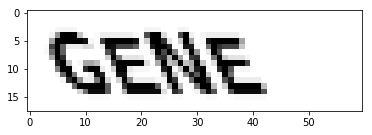

In [4]:
image = create_captcha("GENE", shear=0.5, scale=0.6)
plt.imshow(image, cmap='Greys')

C:\Users\rahul\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


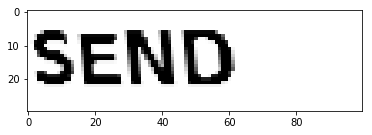

In [5]:
image = create_captcha("SEND", shear=0.1, scale=1.0)
plt.imshow(image, cmap='Greys')

C:\Users\rahul\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


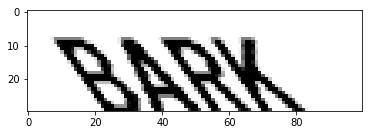

In [6]:
image = create_captcha("BARK", shear=0.8, scale=1.0)
plt.imshow(image, cmap='Greys')

C:\Users\rahul\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


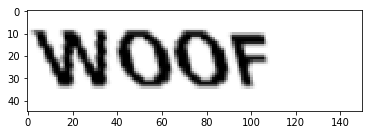

In [7]:
image = create_captcha("WOOF", shear=0.25, scale=1.5)
plt.imshow(image, cmap='Greys')

In [8]:
from skimage.measure import label, regionprops

def segment_image(image):
    # label will find subimages of connected non-black pixels
    labeled_image = label(image>0.2, connectivity=1, background=0)
    subimages = []
    # regionprops splits up the subimages
    for region in regionprops(labeled_image):
        # Extract the subimage
        start_x, start_y, end_x, end_y = region.bbox
        subimages.append(image[start_x:end_x,start_y:end_y])
        if len(subimages) == 0:
            # No subimages found, so return the entire image
            return [image,]
    return subimages

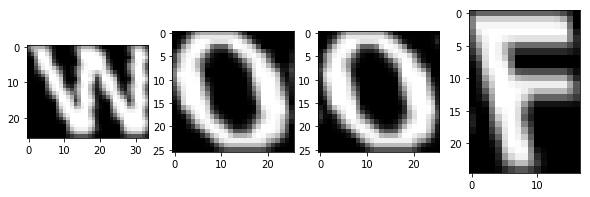

In [9]:
subimages = segment_image(image)

f, axes = plt.subplots(1, len(subimages), figsize=(10, 3))
for i in range(len(subimages)):
    axes[i].imshow(subimages[i], cmap="gray")

C:\Users\rahul\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


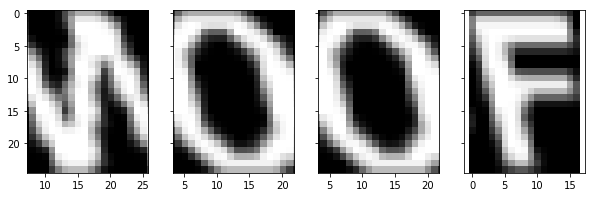

In [10]:
image = create_captcha("WOOF", shear=0.25, scale=1.5)
subimages = segment_image(image)
f, axes = plt.subplots(1, len(subimages), figsize=(10, 3), sharey=True)
for i in range(len(subimages)):
    axes[i].imshow(subimages[i], cmap="gray")

C:\Users\rahul\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


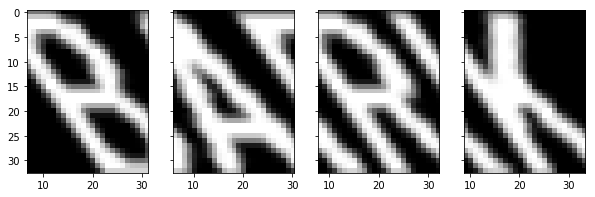

In [11]:
image = create_captcha("BARK", shear=0.8, scale=1.5)
subimages = segment_image(image)
f, axes = plt.subplots(1, len(subimages), figsize=(10, 3), sharey=True) 
for i in range(len(subimages)): 
    axes[i].imshow(subimages[i], cmap="gray")

In [12]:
from sklearn.utils import check_random_state
random_state = check_random_state(14)
letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
shear_values = np.arange(0, 0.5, 0.05)
scale_values = np.arange(0.5, 1.5, 0.1)

In [13]:
def generate_sample(random_state=None):
    random_state = check_random_state(random_state)
    letter = random_state.choice(letters)
    shear = random_state.choice(shear_values)
    scale = random_state.choice(scale_values)
    # We use 30,30 as the image size to ensure we get all the text in the image
    return create_captcha(letter, shear=shear, size=(30, 30), scale=scale), letters.index(letter)

The target for this image is: 11


C:\Users\rahul\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


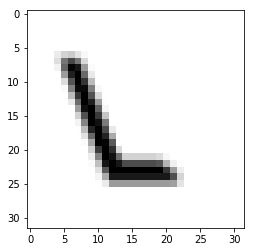

In [14]:
image, target = generate_sample(random_state)
plt.imshow(image, cmap="Greys")
print("The target for this image is: {0}".format(target))

In [15]:
dataset, targets = zip(*(generate_sample(random_state) for i in range(1000)))
dataset = np.array([tf.resize(segment_image(sample)[0], (20, 20)) for sample in dataset])
dataset = np.array(dataset, dtype='float')
targets = np.array(targets)

C:\Users\rahul\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [16]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
y = onehot.fit_transform(targets.reshape(targets.shape[0],1))

In [17]:
y = y.todense()
X = dataset.reshape((dataset.shape[0], dataset.shape[1] * dataset.shape[2]))

In [18]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

C:\Users\rahul\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [19]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(100,), random_state=14)

In [20]:
clf.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_iter': 200,
 'momentum': 0.9,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 14,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [21]:
clf.fit(X_train, y_train)

C:\Users\rahul\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=14, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [22]:
y_pred = clf.predict(X_test)

In [23]:
from sklearn.metrics import f1_score
f1_score(y_pred=y_pred, y_true=y_test, average='macro')

1.0

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_pred=y_pred, y_true=y_test))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         1
          1       1.00      1.00      1.00         1
          2       1.00      1.00      1.00         6
          3       1.00      1.00      1.00         6
          4       1.00      1.00      1.00         3
          5       1.00      1.00      1.00         4
          6       1.00      1.00      1.00         4
          7       1.00      1.00      1.00         4
          8       1.00      1.00      1.00         3
          9       1.00      1.00      1.00         4
         10       1.00      1.00      1.00         4
         11       1.00      1.00      1.00         4
         12       1.00      1.00      1.00         6
         13       1.00      1.00      1.00         5
         14       1.00      1.00      1.00         3
         15       1.00      1.00      1.00         1
         16       1.00      1.00      1.00         7
         17       1.00      1.00      1.00   

In [25]:
def predict_captcha(captcha_image, neural_network):
    subimages = segment_image(captcha_image)
    dataset = np.array([tf.resize(subimage, (20, 20)) for subimage in subimages])
    X_test = dataset.reshape((dataset.shape[0], dataset.shape[1] * dataset.shape[2]))

    y_pred = neural_network.predict_proba(X_test)
    predictions = np.argmax(y_pred, axis=1)
    assert len(y_pred) == len(X_test)
    predicted_word = str.join("", [letters[prediction] for prediction in predictions])
    return predicted_word

In [26]:
clf.predict_proba

<bound method MLPClassifier.predict_proba of MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=14, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)>

GNEE


C:\Users\rahul\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


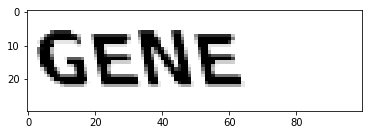

In [27]:
word = "GENE"
captcha = create_captcha(word, shear=0.2)
print(predict_captcha(captcha, clf))
plt.imshow(captcha, cmap="Greys")

In [28]:
def test_prediction(word, net, shear=0.2, scale=1):
    captcha = create_captcha(word, shear=shear, scale=scale, size=(len(word) * 25, 30))
    prediction = predict_captcha(captcha, net)
    return word == prediction, word, prediction

In [29]:
from nltk.corpus import words

In [30]:
valid_words = set([word.upper() for word in words.words() if len(word) == 4])

In [31]:
num_correct = 0
num_incorrect = 0
for word in valid_words:
    shear = random_state.choice(shear_values)
    scale = random_state.choice(scale_values)
    correct, word, prediction = test_prediction(word, clf, shear=shear, scale=scale)
    if correct:
        num_correct += 1
    else:
        num_incorrect += 1
print("Number correct is {0}".format(num_correct))
print("Number incorrect is {0}".format(num_incorrect))

C:\Users\rahul\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Number correct is 2885
Number incorrect is 2110


In [32]:
def evaluation_versus_shear(shear_value):
    num_correct = 0
    num_incorrect = 0
    for word in valid_words:
        scale = random_state.choice(scale_values)
        correct, word, prediction = test_prediction(word, clf, shear=shear_value, scale=scale)
        if correct:
            num_correct += 1
        else:
            num_incorrect += 1
    return num_correct/(num_correct+num_incorrect)

In [33]:
scores = [evaluation_versus_shear(shear) for shear in shear_values]

C:\Users\rahul\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


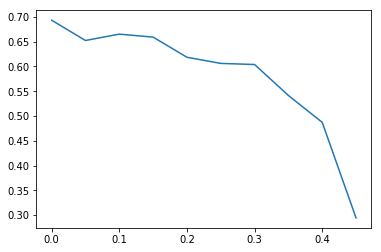

In [34]:
plt.plot(shear_values, scores)

In [35]:
from nltk.metrics import edit_distance
steps = edit_distance("STEP", "STOP")
print("The number of steps needed is: {0}".format(steps))

The number of steps needed is: 1


In [36]:
def compute_distance(prediction, word):
    len_word = min(len(prediction), len(word))
    return len_word - sum([prediction[i] == word[i] for i in range(len_word)])

In [37]:
from operator import itemgetter
def improved_prediction(word, net, dictionary, shear=0.2, scale=1.0):
    captcha = create_captcha(word, shear=shear, scale=scale)
    prediction = predict_captcha(captcha, net)
    if prediction not in dictionary:
        distances = sorted([(word, compute_distance(prediction, word)) for word in dictionary], key=itemgetter(1))
        best_word = distances[0]
        prediction = best_word[0]
    return word == prediction, word, prediction

In [38]:
num_correct = 0
num_incorrect = 0
for word in valid_words:
    shear = random_state.choice(shear_values)
    scale = random_state.choice(scale_values)
    correct, word, prediction = improved_prediction(word, clf, valid_words, shear=shear, scale=scale)
    if correct:
        num_correct += 1
    else:
        num_incorrect += 1
print("Number correct is {0}".format(num_correct))
print("Number incorrect is {0}".format(num_incorrect))

C:\Users\rahul\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Number correct is 3016
Number incorrect is 1979
